In [1]:
!pip install pygame
!pip install gym==0.26.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827632 sha256=b13054bcade5c7588a4059e946e35bab92e7a632bc223708b0b211267cb4acd1
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordEpisodeStatistics
gymlogger.set_level(40) #error only
from torch import nn
import torch
from torch.nn import functional as F
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from base64 import b64encode
from collections import namedtuple, deque
from itertools import count
import torch.optim as optim
from torch.distributions import Categorical
from IPython import display as ipythondisplay
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
class PolicyNet(nn.Module):

  def __init__(self, n_observations, n_actions):
    super(PolicyNet, self).__init__()
    self.layer1 = nn.Linear(n_observations, 64)
    # self.layer2 = nn.Linear(64, 64)
    self.layer3 = nn.Linear(64, n_actions)

  # Called with either one element to determine next action, or a batch
  # during optimization. Returns tensor([[left0exp,right0exp]...]).
  def forward(self, x):
    x = F.tanh(self.layer1(x))
    # x = F.tanh(self.layer2(x))
    return F.softmax(self.layer3(x), dim=1)

In [4]:
gym.__version__

'0.26.2'

In [5]:
env = gym.make('CartPole-v1', render_mode = "rgb_array")

In [6]:
!nvidia-smi

Tue May 23 02:41:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
def init_weights(m):
    #如果是全连接层
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=1)
        m.bias.data.fill_(0.0)

In [8]:
class Agent():
  def __init__(self, env):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.policy_net = PolicyNet(env.observation_space.shape[0], env.action_space.n).to(self.device)
    torch.manual_seed(1)
    self.policy_net.apply(init_weights)

  def select_action(self, state):
    probs = self.policy_net(state)
    m = Categorical(probs)
    action = m.sample()
    return (action, m.log_prob(action))

In [9]:
agent = Agent(env)

In [10]:
LR=0.01
episode_sum = 500
gamma = 0.98

In [11]:
optimizer = optim.Adam(agent.policy_net.parameters(), lr=LR)

In [12]:
loss_list = []
reward_sum_list = []
eps = np.finfo(np.float32).eps.item()
for episode in range(episode_sum):
  state, info = env.reset()
  state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
  log_probs_list = []
  reward_list = []
  temp_reward_sum = 0
  for i in count():
    action, log_prob = agent.select_action(state)
    log_probs_list.append(log_prob)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward_list.append(reward)
    temp_reward_sum += reward
    if terminated:
      next_state = None
    else:
      next_state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
    
    state = next_state
    done = terminated or truncated
    if done:
      discount_reward_list = []
      R = 0
      loss = []
      for r in reward_list[::-1]:
        R = r+gamma*R
        discount_reward_list.insert(0, R)
      discount_reward_list = torch.tensor(discount_reward_list)
      discount_reward_list = (discount_reward_list-discount_reward_list.mean())/(eps+discount_reward_list.std())
      for log_prob, r in zip(log_probs_list, discount_reward_list):
        loss.append(-log_prob * r)
      optimizer.zero_grad()
      loss = torch.cat(loss).sum()
      loss.backward()
      optimizer.step()
      reward_sum_list.append(temp_reward_sum)
      log_probs_list = []
      reward_list = []
      print("the reward of the {}th episode is :{}".format(episode,temp_reward_sum))
      break

the reward of the 0th episode is :67.0
the reward of the 1th episode is :26.0
the reward of the 2th episode is :33.0
the reward of the 3th episode is :27.0
the reward of the 4th episode is :12.0
the reward of the 5th episode is :106.0
the reward of the 6th episode is :58.0
the reward of the 7th episode is :33.0
the reward of the 8th episode is :69.0
the reward of the 9th episode is :56.0
the reward of the 10th episode is :24.0
the reward of the 11th episode is :54.0
the reward of the 12th episode is :45.0
the reward of the 13th episode is :46.0
the reward of the 14th episode is :125.0
the reward of the 15th episode is :116.0
the reward of the 16th episode is :67.0
the reward of the 17th episode is :93.0
the reward of the 18th episode is :63.0
the reward of the 19th episode is :62.0
the reward of the 20th episode is :37.0
the reward of the 21th episode is :71.0
the reward of the 22th episode is :39.0
the reward of the 23th episode is :53.0
the reward of the 24th episode is :78.0
the rew

In [14]:
def draw_pic(x, y, path):
    plt.plot(x, y)
    plt.xlabel("iteration")
    plt.ylabel("reward")
    plt.savefig(path)

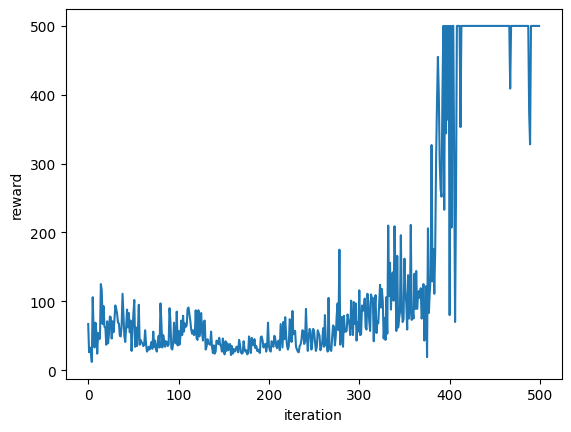

In [15]:
draw_pic(range(len(reward_sum_list)), reward_sum_list, "iteration-sumReward-test")

理论参考自李宏毅老师：https://hackmd.io/@shaoeChen/Bywb8YLKS/https%3A%2F%2Fhackmd.io%2F%40shaoeChen%2FHkH2hSKuS <br>
参数：修改参数有时候不熟练...有点玄学